Importação das bibliotecas necessárias

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import requests
from io import BytesIO
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

1. Coleta de Dados

In [14]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as thezip:
    with thezip.open('SMSSpamCollection') as thefile:
        df = pd.read_csv(thefile, sep='\t', header=None, names=['label', 'text'])

df['email_id'] = df.index

df.head(5600)


,label,text,email_id
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,2
3,ham,U dun say so early hor... U c already then say...,3
4,ham,"Nah I don't think he goes to usf, he lives aro...",4
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,5567
5568,ham,Will ü b going to esplanade fr home?,5568
5569,ham,"Pity, * was in mood for that. So...any other s...",5569
5570,ham,The guy did some bitching but I acted like i'd...,5570


2. Pré-Processamento

In [15]:
# Convertendo as labels para spam (1) e ham (0)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Limpeza dos textos: remoção de caracteres especiais e conversão para minúsculas
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
df['text'] = df['text'].str.lower()

# Tokenização e remoção de stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['text'])

3. Treinamento do Modelo

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.3, random_state=42)

# Modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Modelo SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

4. Validação e Teste

In [17]:
# Avaliação do modelo Naive Bayes
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_nb, zero_division=0))
print("AUC-ROC:", roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Results:
Accuracy: 0.9641148325358851
Precision: 1.0
Recall: 0.7321428571428571
AUC-ROC: 0.9846308948303077
Confusion Matrix:
 [[1448    0]
 [  60  164]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1448
           1       1.00      0.73      0.85       224

    accuracy                           0.96      1672
   macro avg       0.98      0.87      0.91      1672
weighted avg       0.97      0.96      0.96      1672



In [18]:
# Avaliação do modelo SVM
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_svm, zero_division=0))
print("AUC-ROC:", roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Results:
Accuracy: 0.9850478468899522
Precision: 0.9950248756218906
Recall: 0.8928571428571429
AUC-ROC: 0.9920888417521705
Confusion Matrix:
 [[1447    1]
 [  24  200]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.89      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.98      1672



5. Validação Cruzada (Opcional)

In [19]:
# Usando validação cruzada com 5 folds para o modelo Naive Bayes
scores_nb = cross_val_score(nb_model, X, df['label'], cv=5, scoring='accuracy')
print("\nValidação Cruzada (Naive Bayes):")
print("Acurácia média com validação cruzada (5 folds):", scores_nb.mean())

# Usando validação cruzada com 5 folds para o modelo SVM
scores_svm = cross_val_score(svm_model, X, df['label'], cv=5, scoring='accuracy')
print("\nValidação Cruzada (SVM):")
print("Acurácia média com validação cruzada (5 folds):", scores_svm.mean())


Validação Cruzada (Naive Bayes):
Acurácia média com validação cruzada (5 folds): 0.9623107454251233

Validação Cruzada (SVM):
Acurácia média com validação cruzada (5 folds): 0.9752324673338111


6. Visualizações

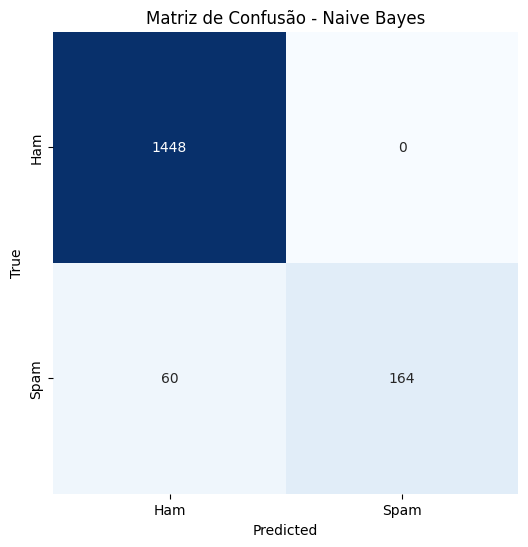

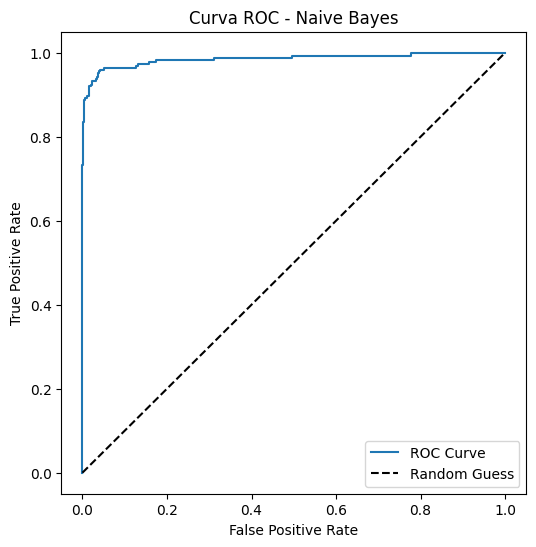

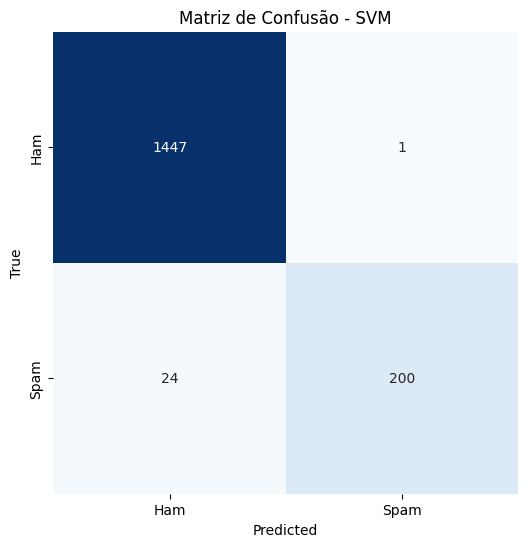

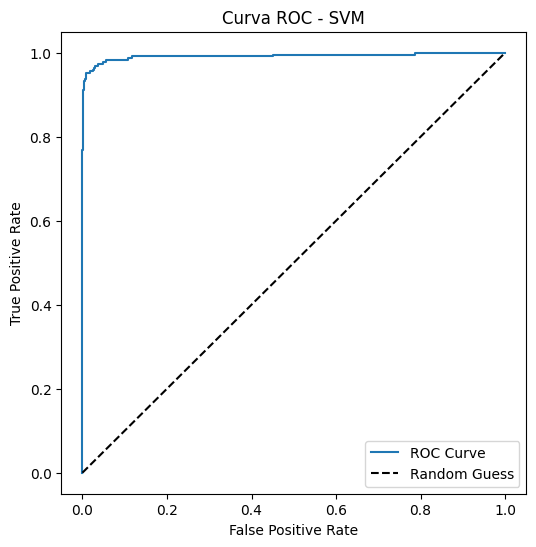

In [20]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Função para plotar a curva ROC
def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Plotando a matriz de confusão e a curva ROC para o modelo Naive Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Matriz de Confusão - Naive Bayes")
plot_roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1], "Curva ROC - Naive Bayes")

# Plotando a matriz de confusão e a curva ROC para o modelo SVM
plot_confusion_matrix(y_test, y_pred_svm, "Matriz de Confusão - SVM")
plot_roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1], "Curva ROC - SVM")